In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

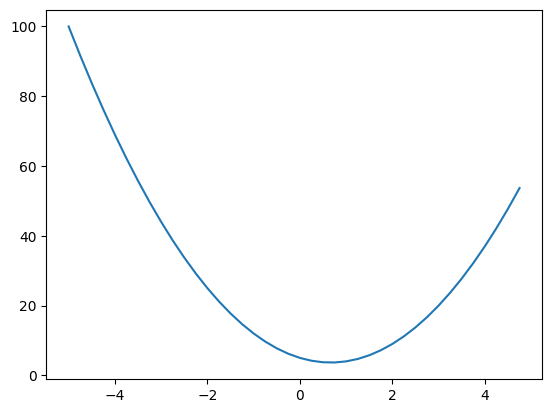

In [6]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [7]:
h = 0.0001
x = -4
(f(x + h) - f(x))/h

-27.999699999980976

why doesn't the function respond when x = 2/3?

In [8]:
h = 0.001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print((d2-d1)/h)

d1 4.0
d2 4.002
1.9999999999997797


why does the slope = 1 for c += h? what about 2 for b += h, and -3 for a +=h?

In [9]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __rmul__(self, other):
        return self * other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other): # other + self
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    # division
    def __truediv__(self, other):
        return self * other**-1

    #subtract
    def __sub__(self, other):
        return self + (-other)

    #multiply self
    def __neg__(self):
        return self * -1

    #power
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad = other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
        

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
        
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
b = Value(5.0)
a = Value(2.0)
a - b

Value(data=-3.0)

In [11]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    assert rankdir in ['LR', 'TB']"""
    
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [12]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

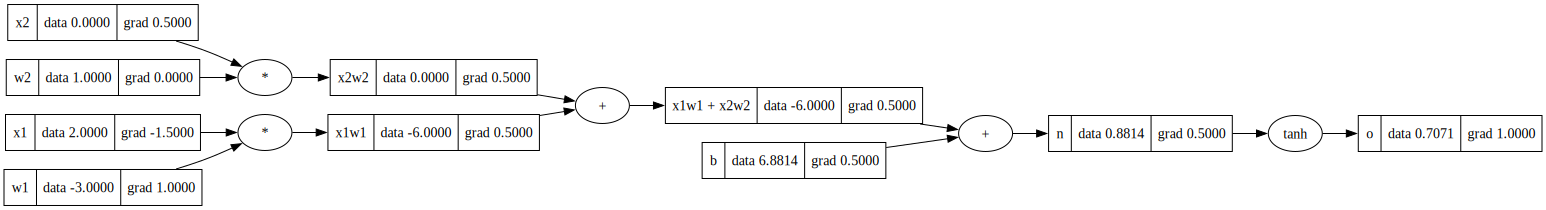

In [13]:
draw_dot(o)

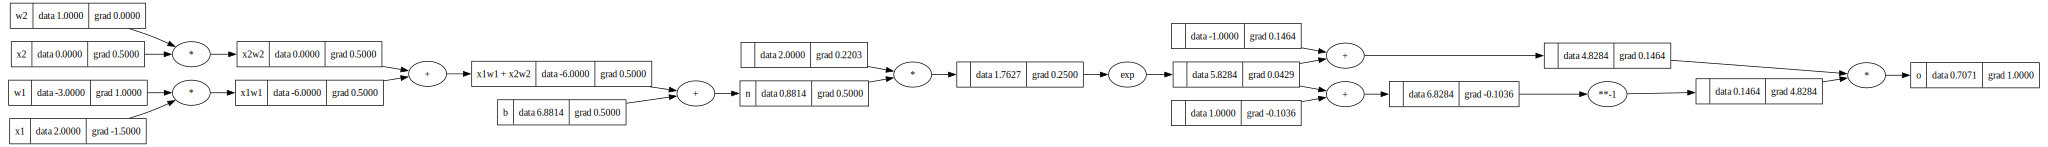

In [14]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1)/(e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [15]:
import torch

In [16]:
torch.Tensor([[0,1,2], [3,4,5]]).shape

torch.Size([2, 3])

In [17]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


list(zip([1], [1, 2]))

In [18]:
import random

In [19]:
class Neuron:
    # properties
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    # method
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # w * x + b
        outs = [n(x) for n in self.neurons]
        return outs[0]if len (outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [20]:
x = [2.0, 3.0, -1.0]
# n = Neuron(2)
# n = Layer(2, 3)
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.5866139967516026)

In [21]:
n.layers[0].neurons[0].w[0].data

-0.0029849718397731984

In [22]:
n.layers[0].neurons[0].w[0].grad

0.0

In [23]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [34]:
for k in range(10):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass:
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #gradient 
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.011669509994064714
1 0.01164771385530311
2 0.011610117407184116
3 0.011602587886611275
4 0.011565300947307506
5 0.011528726029773902
6 0.011508300622869127
7 0.01149850716523422
8 0.011462442097976734
9 0.011425299935199884


In [35]:
ypred

[Value(data=0.9607606183049053),
 Value(data=-0.9191375238095643),
 Value(data=-0.987621058387012),
 Value(data=0.9434881197598239)]